In [1]:
import jax
import jax.numpy as jnp
import jax_dataloader as jdl

import numpyro.distributions as numpyro_dist

from cryojax.inference import distributions as dist
from cryojax.data import (
    RelionParticleParameterFile, 
    RelionParticleStackDataset, 
    simulate_particle_stack)
from cryojax.image import operators as op

import src.ensemble_sim as sim
import src.utils as utils

import matplotlib.pyplot as plt
import os


/mnt/home/levans/venvs/ensemble_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create list of pdb files for simulating images from

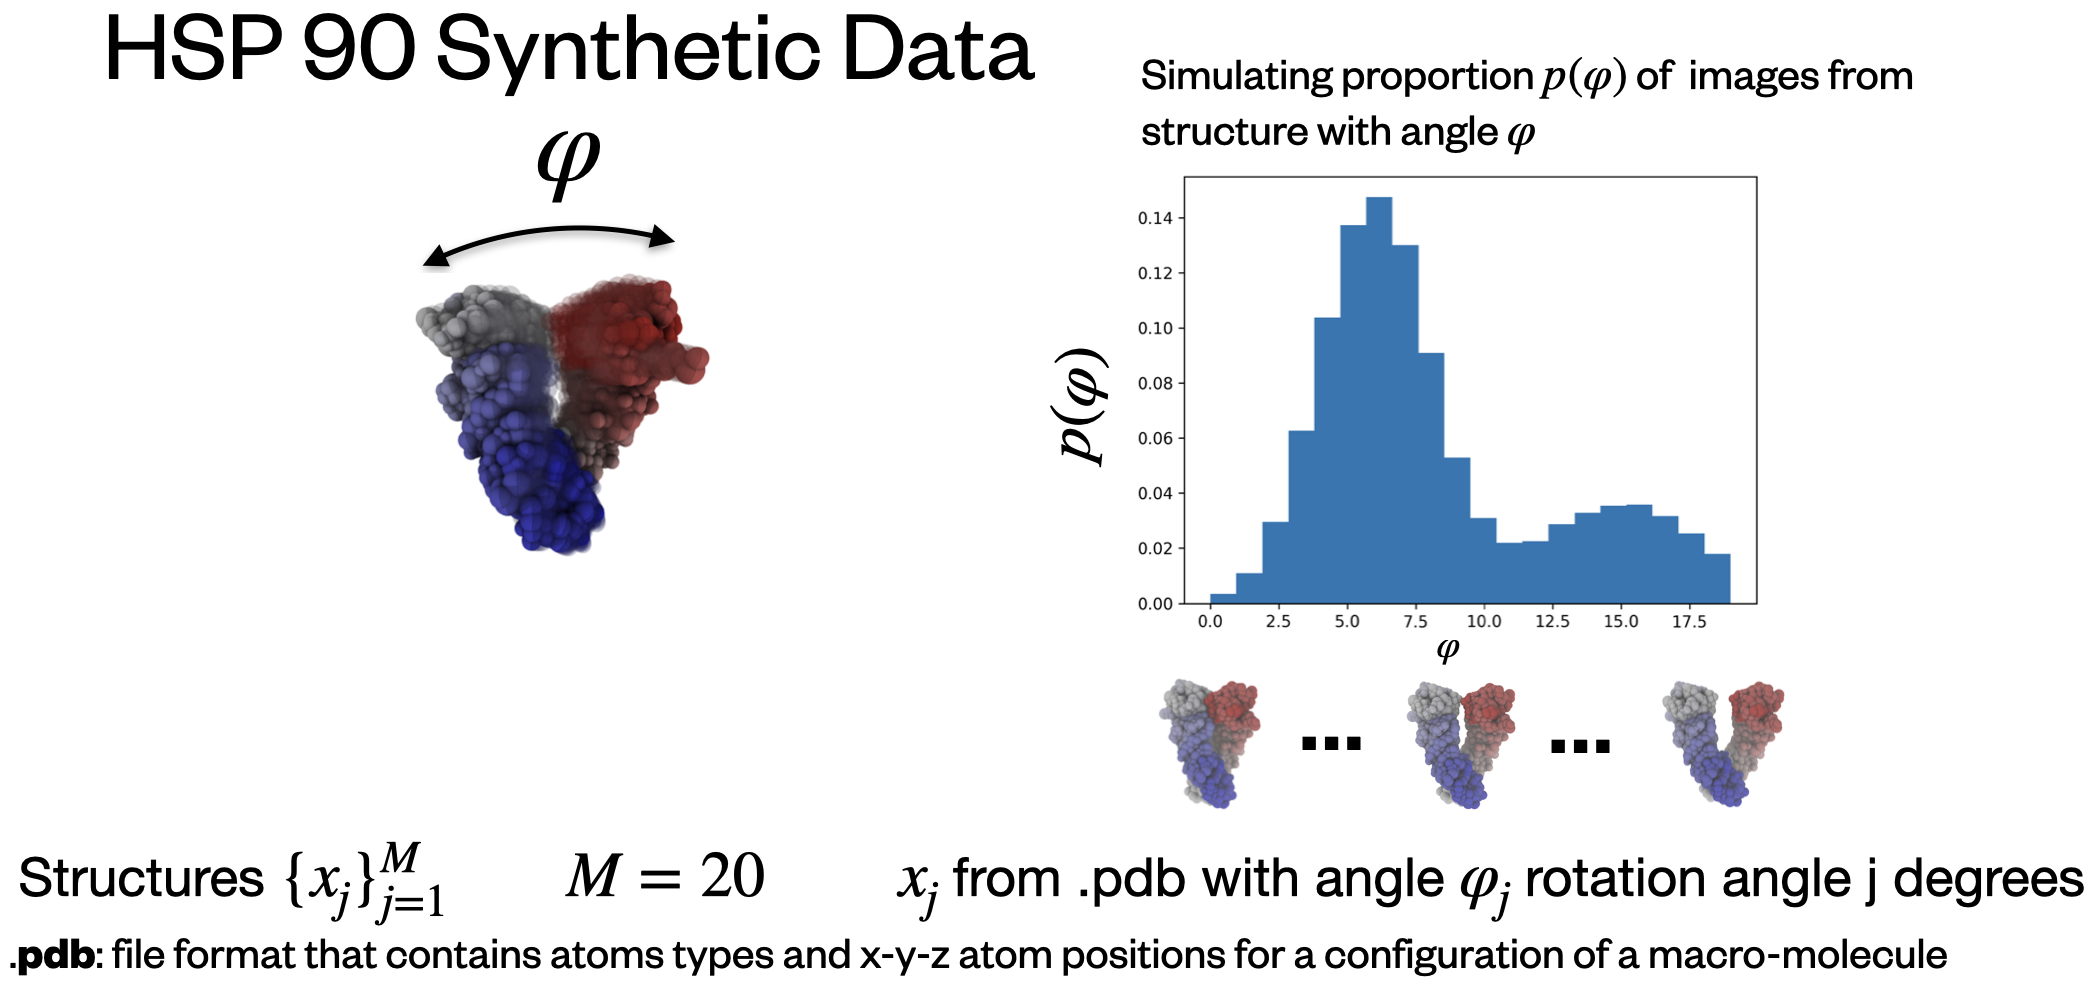

# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

In [2]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


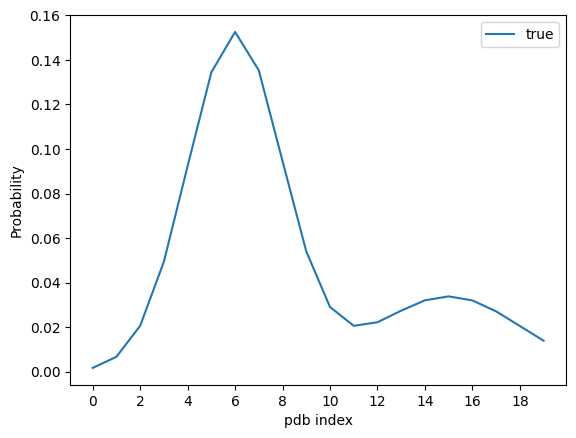

In [3]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = numpyro_dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = numpyro_dist.Normal(loc=means, scale=std_devs) 
    return numpyro_dist.MixtureSameFamily(mixing_dist, component_dist) 

proportions = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(proportions, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
true_weights = jnp.exp(mixture.log_prob(x))
true_weights /= dx*true_weights.sum() 
plt.plot(x, true_weights, label='true', color="C0")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()

#jnp.save("true_weights.npy", true_weights)

# Define a config file for image simulation

In [4]:
# REPLACE with your own favorite directory that can have big files dropped in it
base_directory = "/mnt/home/levans/ceph/cryojax_particles/"
#base_directory = "My favorite directory"

# Adjust names as needed, for saving configs and big image files
path_to_starfile = base_directory + "my_starfile.star"
path_to_images = base_directory

#### Bare bones config for this notebook
## Things that may need to be adjusted:
##   number of images, noise_snr
## Everything else, unlikely
config = {
"number_of_images": 10,
"snr": 0.1,
"weights_models": true_weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"path_to_starfile": path_to_starfile,
"path_to_images": path_to_images,
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}


# Make the parameter file for the dataset and prep the simulator

In [5]:
# Generate RNG keys
number_of_images = config["number_of_images"]
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# make instrument confg
instrument_config = utils.instrument_config_from_params(config)

# make parameters
particle_parameters = sim.make_particle_parameters(keys, instrument_config)

# generate the a "starfile", I/O paradigm for software Relion
new_parameters_file = RelionParticleParameterFile(
    path_to_starfile=config["path_to_starfile"],
    mode="w",
    exists_ok=True,
)
new_parameters_file.append(particle_parameters)
new_parameters_file.save(overwrite=True)

particle_dataset = RelionParticleStackDataset(
    parameter_file=new_parameters_file,
    path_to_relion_project=config["path_to_images"],
    mode="w",
    mrcfile_settings={"overwrite": True}
)

# Create static image formation stuff: potentials, potential integrator
imaging_args = utils.build_image_formation_stuff(config)



# Simulate a dataset!

In [6]:
snr = config["snr"]
mask = op.CircularCosineMask(
    coordinate_grid=instrument_config.coordinate_grid_in_pixels,
    radius=instrument_config.shape[0] //2,
    rolloff_width=0.0
)

constant_args = (imaging_args["potentials"], imaging_args["potential_integrator"], mask, snr)
#print(imaging_args["potentials"])
# Generate RNG keys for per-image noise, and per-image conformations
keys_noise = jax.random.split(jax.random.key(0), number_of_images)
#keys_structure = jax.random.split(jax.random.key(0), number_of_images)
key_structure = jax.random.key(1)

# Generate the per-image conformation assignments: ensemble_weights determines proportion of images simulated at each pdb
ensemble_weights = imaging_args["weights"]
potential_ids = jax.random.choice(
        key_structure, ensemble_weights.shape[0], shape=(number_of_images,), p=ensemble_weights
)

per_particle_args = (keys_noise, potential_ids)

simulate_particle_stack(
    particle_dataset,
    compute_image_fn=sim.compute_image,
    constant_args=constant_args,
    per_particle_args=per_particle_args,
    batch_size=10,
    images_per_file=50,
    overwrite=True
)

### Load Images from Disk, and plot some of them

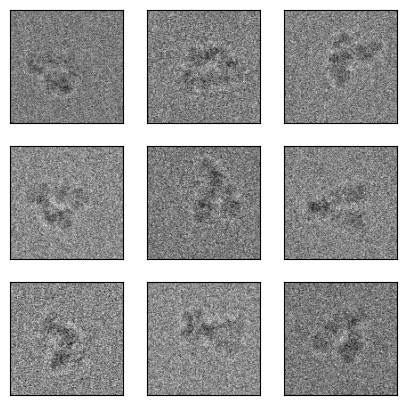

In [7]:
# check first 9 images
image_batch = particle_dataset[0:9]["images"]
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(image_batch[idx, :], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)

# Save a numpy file to disk if needed

In [8]:
#jnp.save(base_directory + "hsp90_low_snr_images.npz", particle_reader[:].images)
